<a href="https://colab.research.google.com/github/ssyss-513/MyColab/blob/main/COMP5434/5434_task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Data Acquisition
df = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
print("✅ Data Loaded Successfully!")
print(df.head(), "\n")
print(df.info(), "\n")
print(df_test.head(), "\n")
print(df_test.info(), "\n")

✅ Data Loaded Successfully!
   id  magnitude  depth  cdi  mmi  sig  label
0   1        6.9     25    4    4  -33      0
1   2        7.0    579    3    3  -13      0
2   3        6.6    624    0    2  -98      0
3   4        6.8    630    1    3  -57      0
4   5        6.7     20    7    6   29      0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 909 entries, 0 to 908
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         909 non-null    int64  
 1   magnitude  909 non-null    float64
 2   depth      909 non-null    int64  
 3   cdi        909 non-null    int64  
 4   mmi        909 non-null    int64  
 5   sig        909 non-null    int64  
 6   label      909 non-null    int64  
dtypes: float64(1), int64(6)
memory usage: 49.8 KB
None 

       id  magnitude  depth  cdi  mmi  sig
0  100001        7.0     14    8    7    0
1  100002        7.3     37    5    5   65
2  100003        7.0    660    4    3  -13


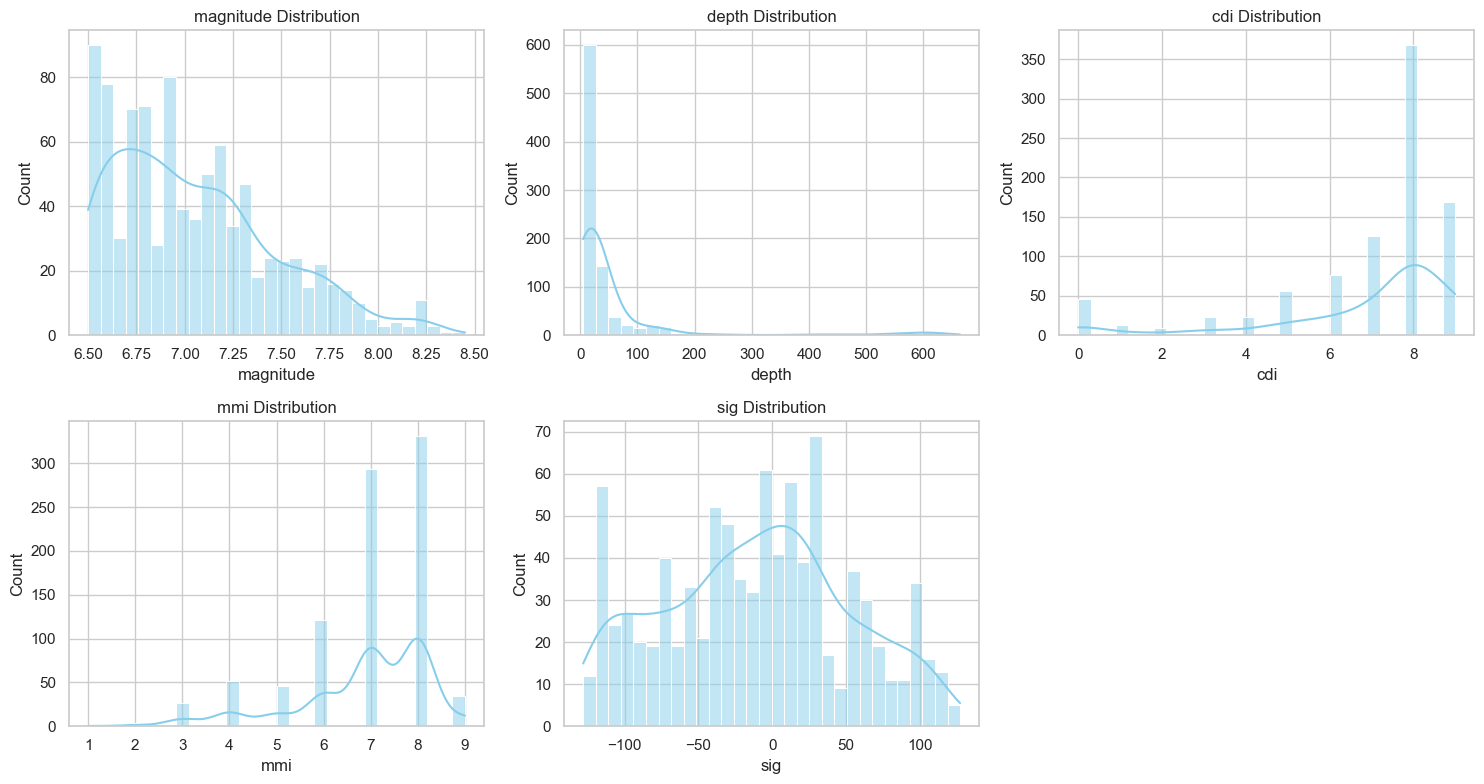

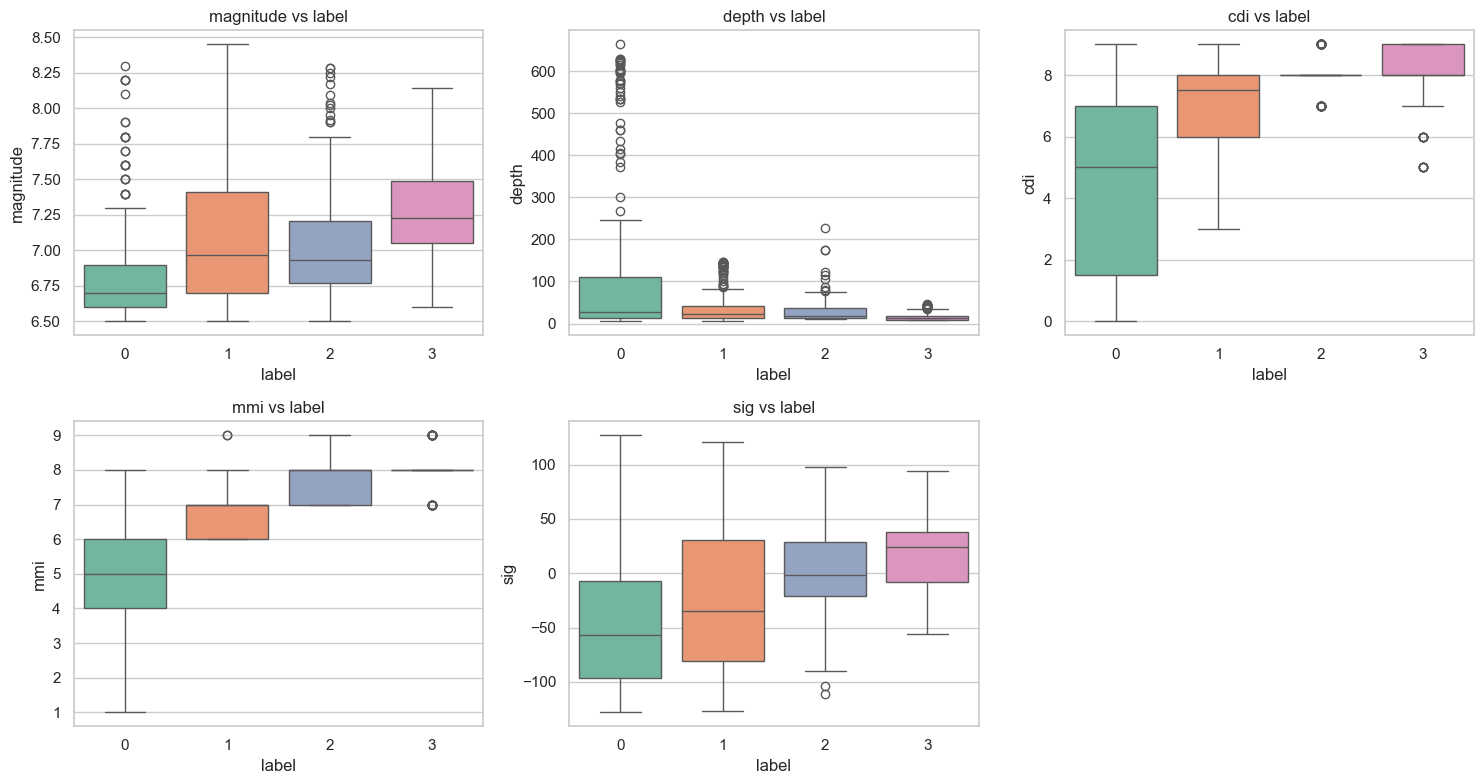

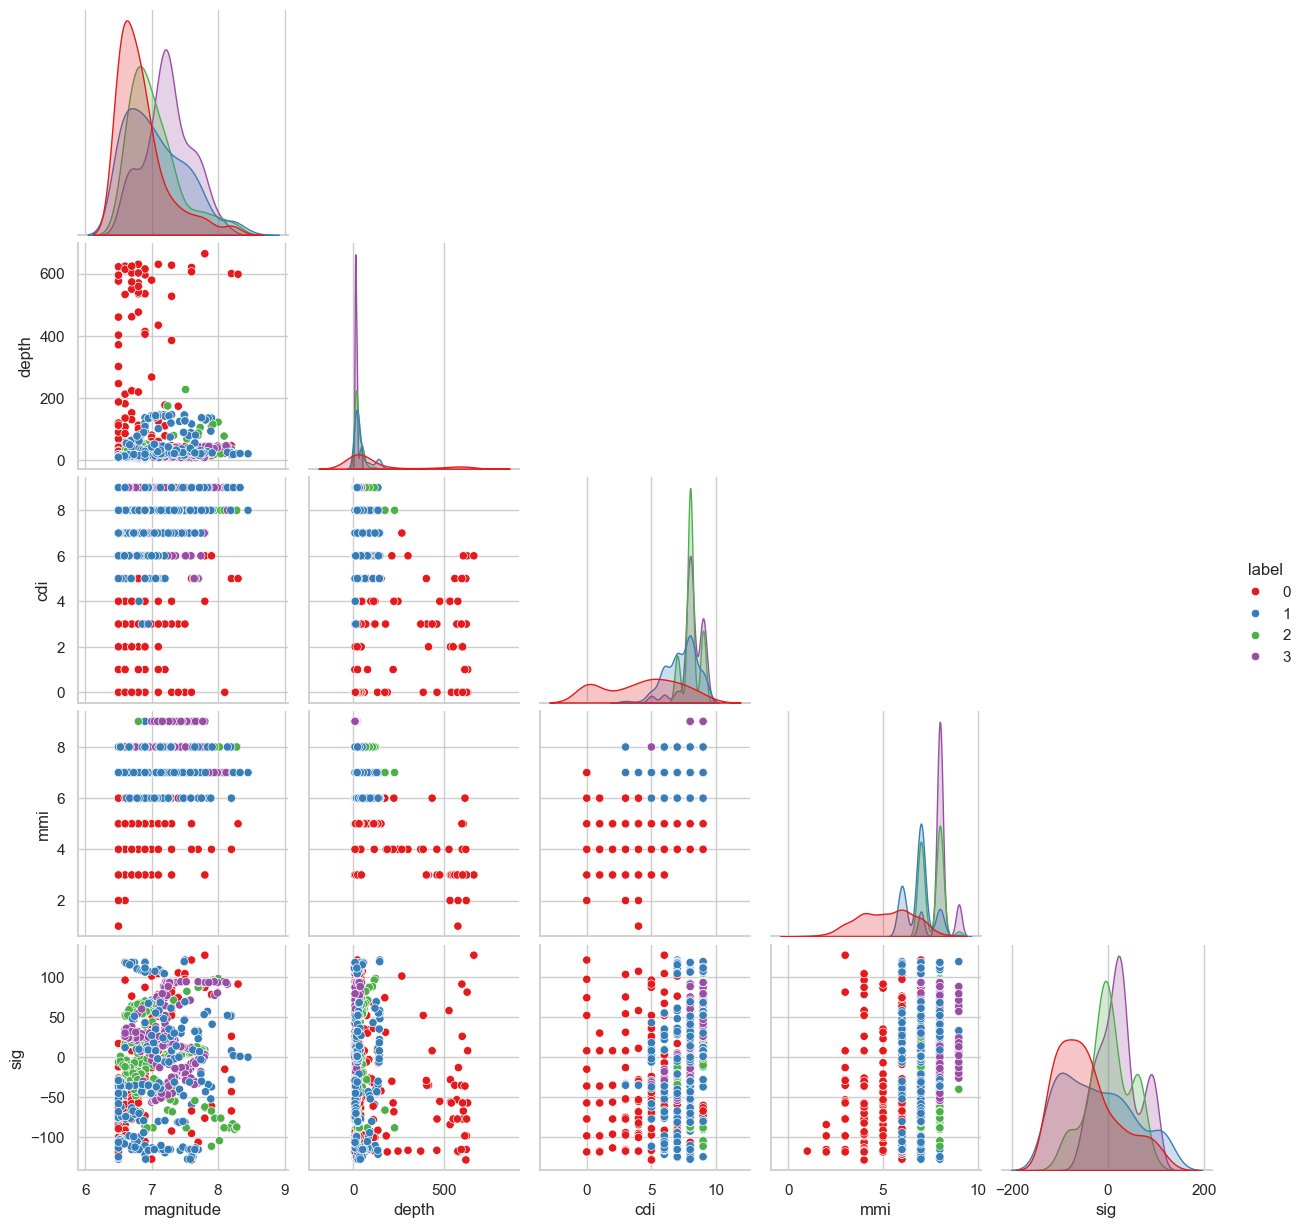

In [ ]:
# Exploratory Data Analysis (EDA)
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_theme(style="whitegrid")

features = ['magnitude', 'depth', 'cdi', 'mmi', 'sig']

# 直方图
plt.figure(figsize=(15, 8))
for i, col in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], bins=30, kde=True, color='skyblue')
    plt.title(f'{col} Distribution')
plt.tight_layout()
plt.show()

# 箱型图
plt.figure(figsize=(15, 8))
for i, col in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='label', y=col, data=df, hue='label', palette='Set2', legend=False)
    plt.title(f'{col} vs label')
plt.tight_layout()
plt.show()

# 散点图矩阵
sns.pairplot(df, vars=features, hue='label', palette='Set1', corner=True)
plt.show()


In [ ]:
from scipy import stats
# 定义特征列
feature_cols = ['magnitude', 'depth', 'cdi', 'mmi', 'sig']

z_scores = np.abs(stats.zscore(df[feature_cols]))

# 设置阈值
threshold = 3

outliers = (z_scores > threshold)

# 统计每列异常值数量
outlier_counts = np.sum(outliers, axis=0)
print("每个特征的异常值数量：")
for col, count in zip(feature_cols, outlier_counts):
    print(f"{col}: {count}")

# 删除包含异常值的样本（如果某行任意列是异常值）
df_cleaned = df[(z_scores < threshold).all(axis=1)]

print(f"\n原始样本数: {len(df)}, 清洗后样本数: {len(df_cleaned)}")
print(f"共删除 {len(df) - len(df_cleaned)} 个异常样本")

print("\n✅ 清洗后数据预览：")
print(df_cleaned.head())

每个特征的异常值数量：
magnitude: 2
depth: 36
cdi: 0
mmi: 5
sig: 0

原始样本数: 909, 清洗后样本数: 871
共删除 38 个异常样本

✅ 清洗后数据预览：
   id  magnitude  depth  cdi  mmi  sig  label
0   1        6.9     25    4    4  -33      0
4   5        6.7     20    7    6   29      0
5   6        7.6     26    9    8    7      1
6   7        6.9     10    9    9  119      1
7   8        6.5     10    7    7  -12      0


Each feature relationship VS label

In [4]:
corr = df.corr()['label'].abs().sort_values(ascending=False)
print(corr)

label        1.000000
mmi          0.749104
cdi          0.610180
id           0.430429
sig          0.395159
depth        0.345300
magnitude    0.315328
Name: label, dtype: float64


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

# 处理 depth 的异常值
# print(f"depth 中小于 -1 的值数量：{(df_cleaned['depth'] < -1).sum()}")
# Step 1: 对 depth 先对数压缩
df_cleaned['depth'] = np.log1p(df_cleaned['depth'])

# Step 2: 再标准化 depth 和 sig
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_cleaned[['depth', 'sig']] = scaler.fit_transform(df_cleaned[['depth', 'sig']])

# Feature Engineering
print("\n🔬 Performing Feature Engineering...")

df_cleaned['cdi_mmi_interaction'] = df_cleaned['cdi'] * df_cleaned['mmi']

df_cleaned['cdi_sq'] = df_cleaned['cdi']**2
df_cleaned['mmi_sq'] = df_cleaned['mmi']**2

print("✅ New features created: 'cdi_mmi_interaction', 'cdi_sq', 'mmi_sq'")
print(df_cleaned.head())

X = df_cleaned.drop(columns=["id", "label"]).values

# same in test set
df_test_processed = df_test.copy()
df_test_processed['depth'] = np.log1p(df_test_processed['depth'])
df_test_processed[['depth', 'sig']] = scaler.transform(df_test_processed[['depth', 'sig']])
df_test_processed['cdi_mmi_interaction'] = df_test_processed['cdi'] * df_test_processed['mmi']
df_test_processed['cdi_sq'] = df_test_processed['cdi']**2
df_test_processed['mmi_sq'] = df_test_processed['mmi']**2
X_submission = df_test_processed.drop(columns=["id"]).values


y = df_cleaned["label"].values

print("\n✅ Data prepared for 10-fold Cross-Validation.")



🔬 Performing Feature Engineering...
✅ New features created: 'cdi_mmi_interaction', 'cdi_sq', 'mmi_sq'
   id  magnitude     depth  cdi  mmi       sig  label  cdi_mmi_interaction  \
0   1        6.9  1.173302    4    4  0.626415      0                   16   
4   5        6.7  0.898983    7    6  1.617344      0                   42   
5   6        7.6  1.221776    9    8  1.265724      1                   72   
6   7        6.9  0.068444    9    9  3.055788      1                   81   
7   8        6.5  0.068444    7    7  0.962053      0                   49   

   cdi_sq  mmi_sq  
0      16      16  
4      49      36  
5      81      64  
6      81      81  
7      49      49  

✅ Data prepared for 10-fold Cross-Validation.


/var/folders/bq/7xc8v0_n0xvdrksns142rb880000gn/T/ipykernel_70349/1198064475.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['depth'] = np.log1p(df_cleaned['depth'])
/var/folders/bq/7xc8v0_n0xvdrksns142rb880000gn/T/ipykernel_70349/1198064475.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[['depth', 'sig']] = scaler.fit_transform(df_cleaned[['depth', 'sig']])+1
/var/folders/bq/7xc8v0_n0xvdrksns142rb880000gn/T/ipykernel_70349/1198064475.py:22: SettingWithCopyWarning: 
A value is 

对比清洗前后的数据分布

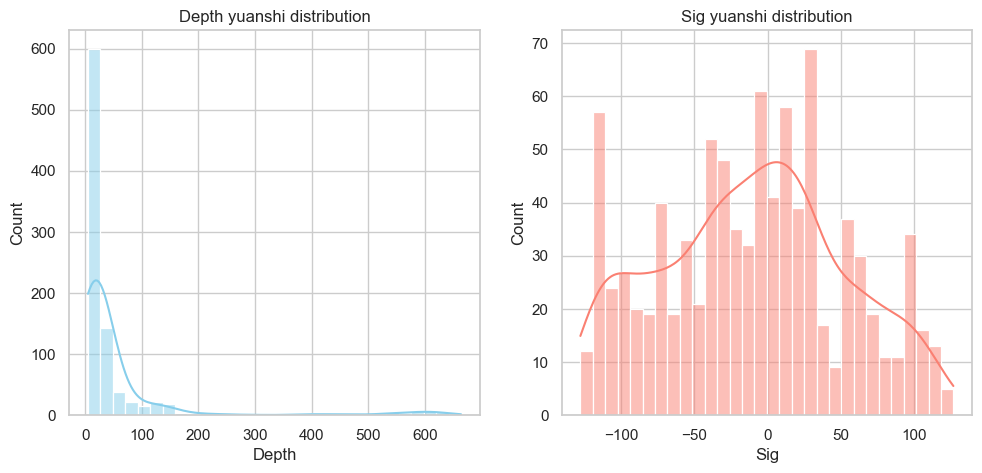

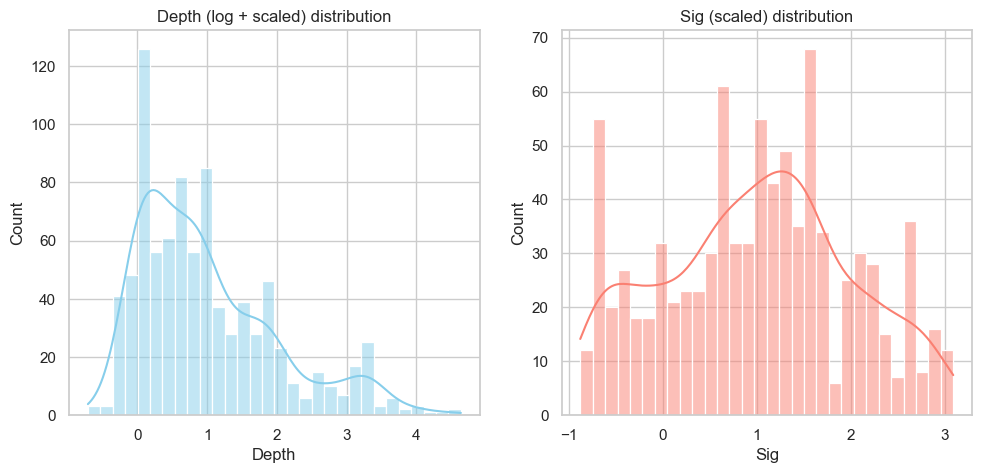

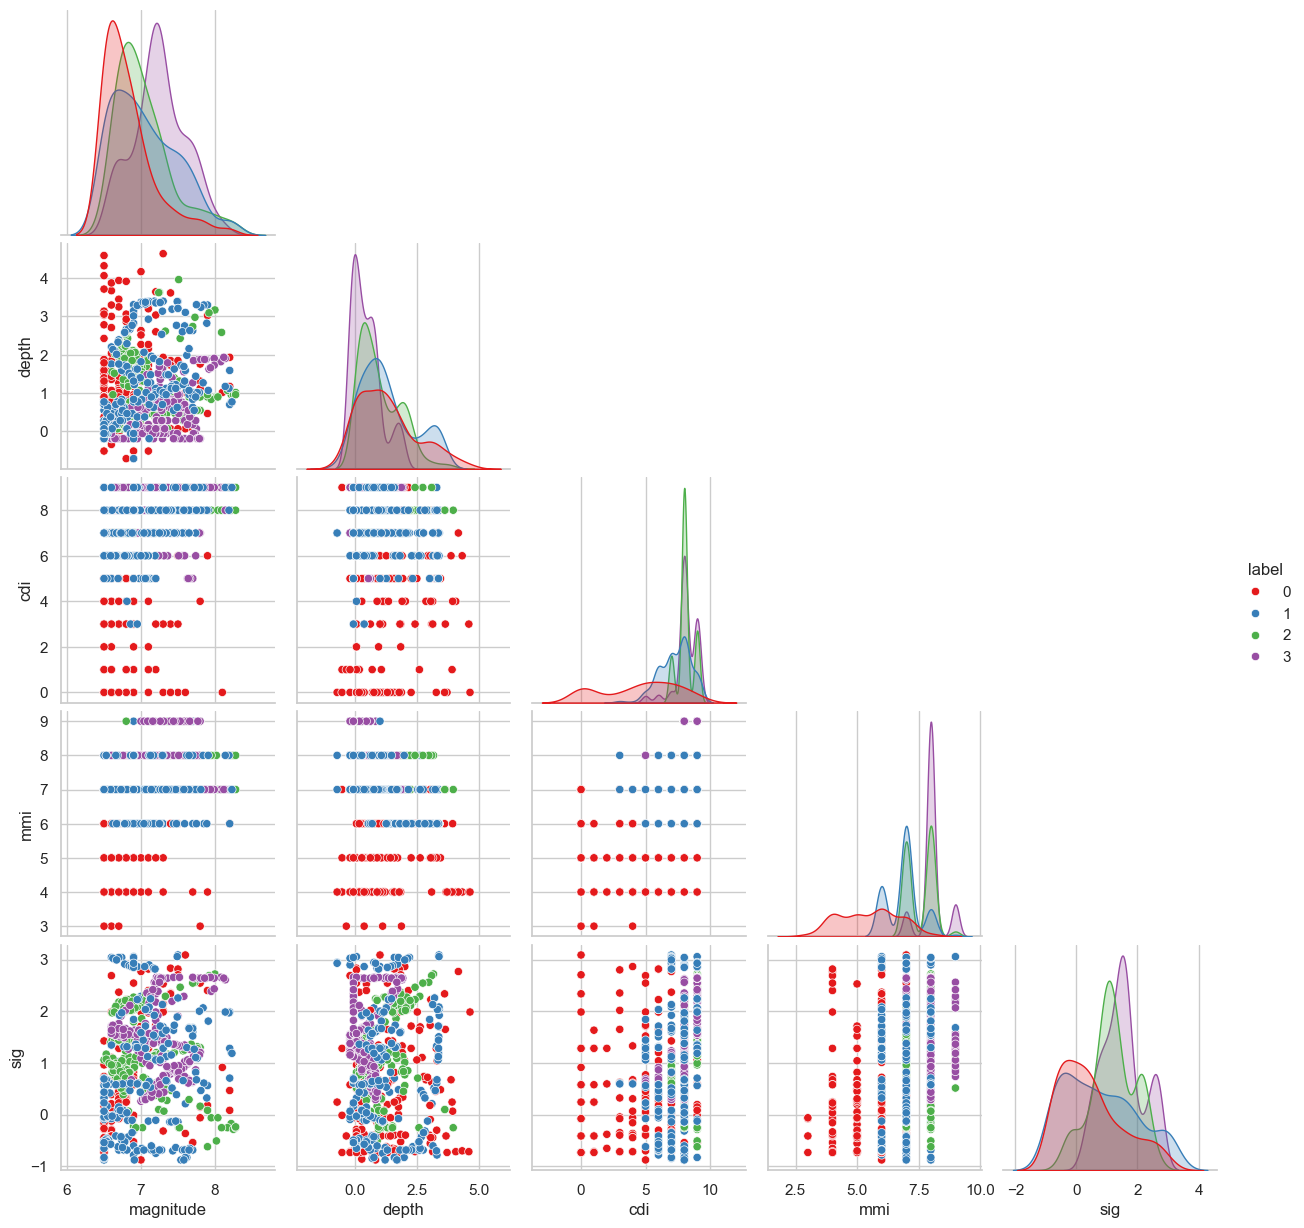

In [ ]:
plt.figure(figsize=(18,5))

# 1️⃣ depth 分布
plt.subplot(1,3,1)
sns.histplot(df['depth'], kde=True, bins=30, color='skyblue')
plt.title('Depth yuanshi distribution')
plt.xlabel('Depth')
plt.ylabel('Count')

# 2️⃣ sig 分布
plt.subplot(1,3,2)
sns.histplot(df['sig'], kde=True, bins=30, color='salmon')
plt.title('Sig yuanshi distribution')
plt.xlabel('Sig')
plt.ylabel('Count')


plt.figure(figsize=(18,5))

#cleaned data

# 1️⃣ depth 分布
plt.subplot(1,3,1)
sns.histplot(df_cleaned['depth'], kde=True, bins=30, color='skyblue')
plt.title('Depth (log + scaled) distribution')
plt.xlabel('Depth')
plt.ylabel('Count')

# 2️⃣ sig 分布
plt.subplot(1,3,2)
sns.histplot(df_cleaned['sig'], kde=True, bins=30, color='salmon')
plt.title('Sig (scaled) distribution')
plt.xlabel('Sig')
plt.ylabel('Count')


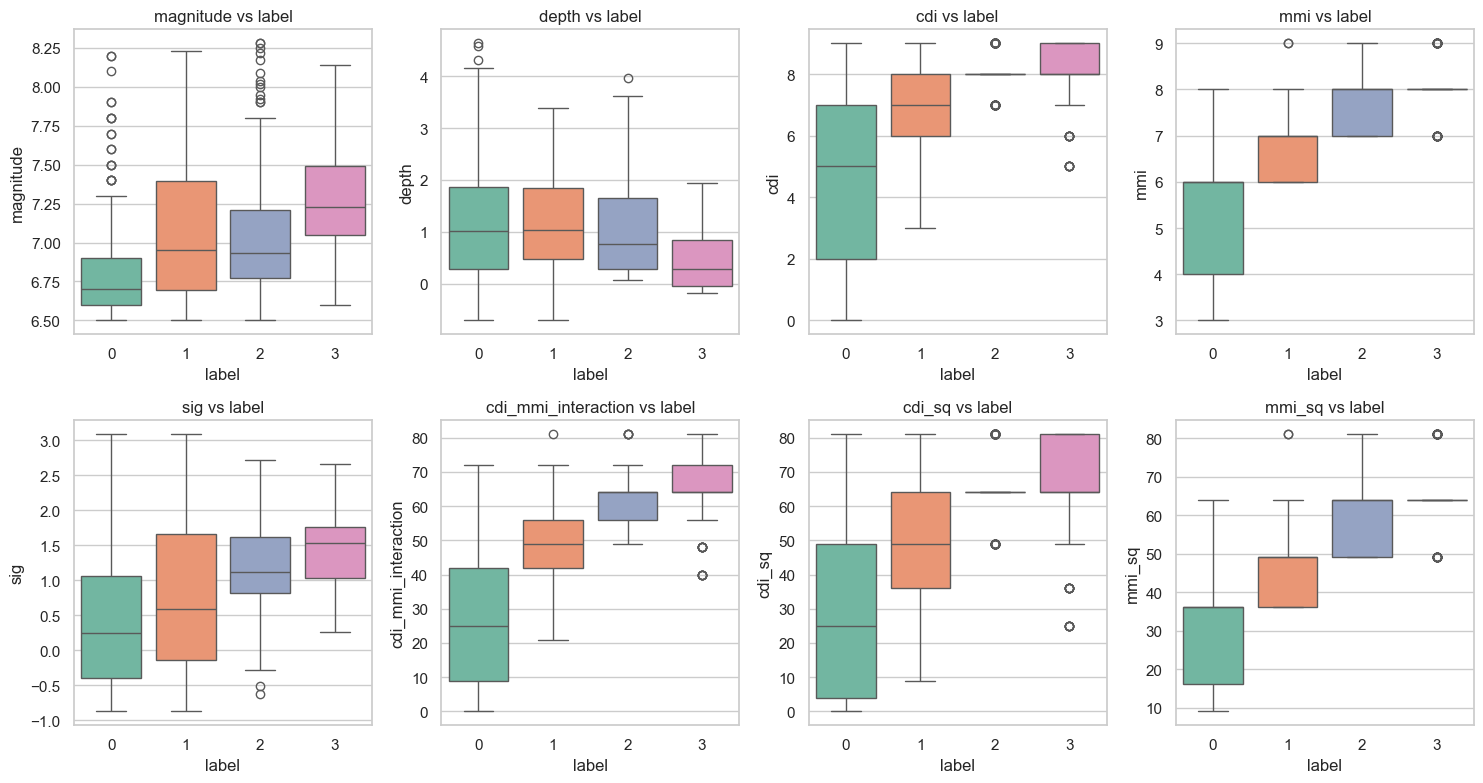

In [6]:
features_new = ['magnitude', 'depth', 'cdi', 'mmi', 'sig', 'cdi_mmi_interaction', 'cdi_sq', 'mmi_sq']

plt.figure(figsize=(15, 8))
for i, col in enumerate(features_new, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(x='label', y=col, data=df_cleaned, hue='label', palette='Set2', legend=False)
    plt.title(f'{col} vs label')
plt.tight_layout()
plt.show()

Original dataset shape Counter({np.int64(1): 230, np.int64(3): 229, np.int64(2): 213, np.int64(0): 199})
Resampled dataset shape Counter({np.int64(0): 230, np.int64(1): 230, np.int64(2): 230, np.int64(3): 230})


/var/folders/bq/7xc8v0_n0xvdrksns142rb880000gn/T/ipykernel_70349/372468886.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette='Set2')
/var/folders/bq/7xc8v0_n0xvdrksns142rb880000gn/T/ipykernel_70349/372468886.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_resampled, palette='Set2')


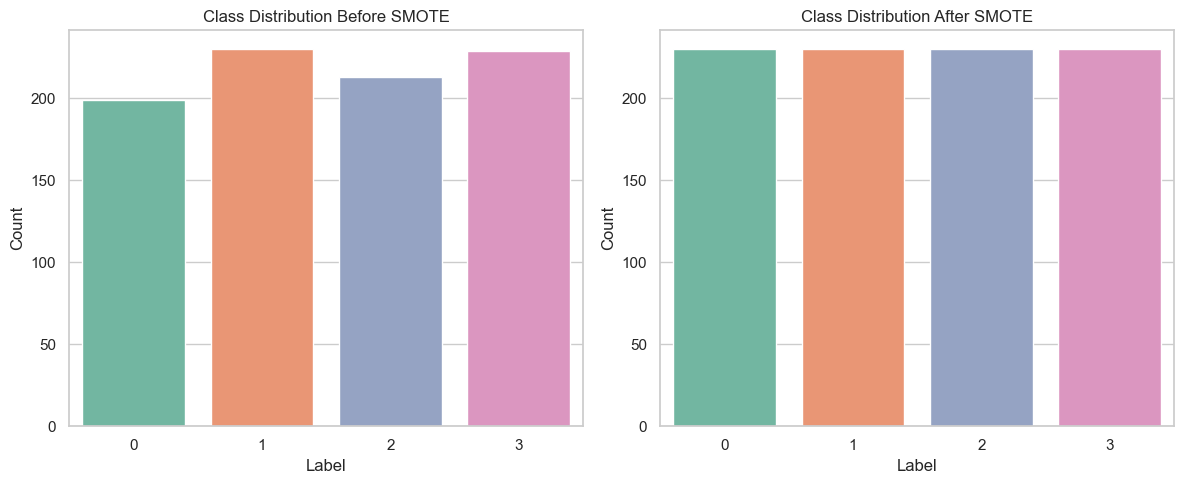

In [ ]:
import collections
from imblearn.over_sampling import SMOTE

# Show class distribution on the full dataset before SMOTE
print("Original dataset shape %s" % collections.Counter(y))

sm = SMOTE(random_state=5434)
X_resampled, y_resampled = sm.fit_resample(X, y)

print("Resampled dataset shape %s" % collections.Counter(y_resampled))

# Visualize
plt.figure(figsize=(12, 5))

# Before SMOTE
plt.subplot(1, 2, 1)
sns.countplot(x=y, palette='Set2')
plt.title("Class Distribution Before SMOTE")
plt.xlabel("Label")
plt.ylabel("Count")

# After SMOTE
plt.subplot(1, 2, 2)
sns.countplot(x=y_resampled, palette='Set2')
plt.title("Class Distribution After SMOTE")
plt.xlabel("Label")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


In [9]:
import itertools
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE

class TreeNode:
    """Decision Tree Node for XGBoost"""
    def __init__(self, split_feature=None, split_value=None, leaf_value=None):
        self.split_feature = split_feature
        self.split_value = split_value
        self.leaf_value = leaf_value
        self.left_child = None
        self.right_child = None

class DecisionTree:
    """Regression Tree for XGBoost"""
    def __init__(self, max_depth=3, min_samples_split=2, reg_lambda=1.0, gamma=0.0):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.reg_lambda = reg_lambda
        self.gamma = gamma
        self.root = None

    def _calculate_gain(self, G_H_tuple):
        G_L, H_L, G_R, H_R = G_H_tuple
        gain = 0.5 * (
            (G_L**2 / (H_L + self.reg_lambda)) +
            (G_R**2 / (H_R + self.reg_lambda)) -
            ((G_L + G_R)**2 / (H_L + H_R + self.reg_lambda))
        ) - self.gamma
        return gain

    def _find_best_split(self, X, grad, hess):
        best_gain = -1
        best_split = (None, None)
        n_features = X.shape[1]
        G_total = np.sum(grad)
        H_total = np.sum(hess)

        for feature_idx in range(n_features):
            unique_values = np.unique(X[:, feature_idx])
            for split_value in unique_values:
                left_mask = X[:, feature_idx] < split_value
                right_mask = ~left_mask
                G_L, H_L = np.sum(grad[left_mask]), np.sum(hess[left_mask])
                G_R, H_R = G_total - G_L, H_total - H_L
                if H_L < 1e-6 or H_R < 1e-6:
                    continue
                gain = self._calculate_gain((G_L, H_L, G_R, H_R))
                if gain > best_gain:
                    best_gain = gain
                    best_split = (feature_idx, split_value)
        return best_split, best_gain

    def _build_tree(self, X, grad, hess, depth):
        if depth >= self.max_depth or len(X) < self.min_samples_split:
            leaf_value = -np.sum(grad) / (np.sum(hess) + self.reg_lambda)
            return TreeNode(leaf_value=leaf_value)
        (split_feature, split_value), gain = self._find_best_split(X, grad, hess)
        if gain <= 0 or split_feature is None:
            leaf_value = -np.sum(grad) / (np.sum(hess) + self.reg_lambda)
            return TreeNode(leaf_value=leaf_value)
        node = TreeNode(split_feature=split_feature, split_value=split_value)
        left_mask = X[:, split_feature] < split_value
        right_mask = ~left_mask
        node.left_child = self._build_tree(X[left_mask], grad[left_mask], hess[left_mask], depth + 1)
        node.right_child = self._build_tree(X[right_mask], grad[right_mask], hess[right_mask], depth + 1)
        return node

    def fit(self, X, grad, hess):
        self.root = self._build_tree(X, grad, hess, 0)

    def predict(self, X):
        predictions = np.zeros(len(X))
        for i, x in enumerate(X):
            node = self.root
            while node.leaf_value is None:
                if x[node.split_feature] < node.split_value:
                    node = node.left_child
                else:
                    node = node.right_child
            predictions[i] = node.leaf_value
        return predictions

class CustomXGBoost:
    """Custom XGBoost for multi-class classification."""
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, reg_lambda=1.0, gamma=0.0):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.reg_lambda = reg_lambda
        self.gamma = gamma
        self.trees = {}

    def _sigmoid(self, x):
        x = np.clip(x, -500, 500)
        return 1 / (1 + np.exp(-x))

    def fit(self, X, y, verbose=False):
        self.classes_ = np.unique(y)
        self.n_classes_ = len(self.classes_)
        
        raw_preds = np.zeros((len(X), self.n_classes_))

        for class_idx in self.classes_:
            if verbose:
                print(f"Training for class {class_idx}...")
            self.trees[class_idx] = []
            y_binary = (y == class_idx).astype(int)
            
            # Initialize with a small value to avoid issues with log(0)
            class_preds = np.full(len(X), 0.5)

            for _ in range(self.n_estimators):
                probs = self._sigmoid(class_preds)
                grad = probs - y_binary
                hess = probs * (1 - probs)
                
                tree = DecisionTree(max_depth=self.max_depth, reg_lambda=self.reg_lambda, gamma=self.gamma)
                tree.fit(X, grad, hess)
                
                update = tree.predict(X)
                class_preds += self.learning_rate * update
                self.trees[class_idx].append(tree)
            raw_preds[:, class_idx] = class_preds


    def predict_proba(self, X):
        raw_preds = np.zeros((len(X), self.n_classes_))
        for class_idx in self.classes_:
            class_preds = np.full(len(X), 0.5)
            for tree in self.trees[class_idx]:
                class_preds += self.learning_rate * tree.predict(X)
            raw_preds[:, class_idx] = class_preds
        
        exp_preds = np.exp(raw_preds - np.max(raw_preds, axis=1, keepdims=True))
        return exp_preds / np.sum(exp_preds, axis=1, keepdims=True)

    def predict(self, X):
        probas = self.predict_proba(X)
        return np.argmax(probas, axis=1)

# ===================================================================
# Step 3.4: Grid Search with SMOTE and 10-Fold Cross-Validation
# ===================================================================
print("🚀 Starting Grid Search for Custom XGBoost with SMOTE and 10-Fold CV...")

param_grid = {
    'learning_rate': [0.01, 0.02],
    'max_depth': [7],
    'n_estimators': [2000],
    'reg_lambda': [1.0],
    'gamma': [0.7, 0.6]
}
keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

best_score = -1
best_params = None

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5434)
sm = SMOTE(random_state=5434)

for i, params in enumerate(param_combinations):
    print(f"--- Testing Combination {i+1}/{len(param_combinations)} ---")
    print(params)
    
    fold_scores = []
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"  -- Fold {fold+1}/10 --")
        X_train_fold, y_train_fold = X[train_idx], y[train_idx]
        X_val_fold, y_val_fold = X[val_idx], y[val_idx]
        
        # Apply SMOTE only to the training data of this fold
        X_train_resampled, y_train_resampled = sm.fit_resample(X_train_fold, y_train_fold)
        
        xgb = CustomXGBoost(**params)
        xgb.fit(X_train_resampled, y_train_resampled)
        
        y_pred_val = xgb.predict(X_val_fold)
        score = f1_score(y_val_fold, y_pred_val, average="macro")
        fold_scores.append(score)
    
    mean_score = np.mean(fold_scores)
    print(f"Average Macro-F1 Score for this combination: {mean_score:.4f}")
    
    if mean_score > best_score:
        best_score = mean_score
        best_params = params
        print(f"🎉 New Best Score! 🎉")

print("================================================")
print(f"✅ Grid Search Complete!")
print(f"🏆 Best CV Macro-F1 Score: {best_score:.4f}")
print(f"🔧 Best Hyperparameters: {best_params}")
print("================================================")

print("🚀 Training Final Custom XGBoost Model with Best Hyperparameters on Full Data...")

# Apply SMOTE to the entire dataset for final training
X_resampled_full, y_resampled_full = sm.fit_resample(X, y)

final_xgb = CustomXGBoost(**best_params)
final_xgb.fit(X_resampled_full, y_resampled_full, verbose=True)

print("✅ Final model trained.")


🚀 Starting Grid Search for Custom XGBoost with SMOTE and 10-Fold CV...
--- Testing Combination 1/4 ---
{'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 2000, 'reg_lambda': 1.0, 'gamma': 0.7}
  -- Fold 1/10 --
  -- Fold 2/10 --
  -- Fold 3/10 --
  -- Fold 4/10 --
  -- Fold 5/10 --
Average Macro-F1 Score for this combination: 0.8562
🎉 New Best Score! 🎉
--- Testing Combination 2/4 ---
{'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 2000, 'reg_lambda': 1.0, 'gamma': 0.6}
  -- Fold 1/10 --
  -- Fold 2/10 --
  -- Fold 3/10 --
  -- Fold 4/10 --
  -- Fold 5/10 --
Average Macro-F1 Score for this combination: 0.8572
🎉 New Best Score! 🎉
--- Testing Combination 3/4 ---
{'learning_rate': 0.02, 'max_depth': 7, 'n_estimators': 2000, 'reg_lambda': 1.0, 'gamma': 0.7}
  -- Fold 1/10 --
  -- Fold 2/10 --
  -- Fold 3/10 --
  -- Fold 4/10 --
  -- Fold 5/10 --
Average Macro-F1 Score for this combination: 0.8562
--- Testing Combination 4/4 ---
{'learning_rate': 0.02, 'max_depth': 7, 'n_estimat

In [10]:
# X_submission is already prepared and scaled
print("\n🚀 Generating predictions for submission...")

# Use the FINAL trained XGBoost model to predict
y_pred_submission_xgb = final_xgb.predict(X_submission)

# Save the prediction results
submission_xgb = pd.DataFrame({
    "id": df_test["id"],
    "label": y_pred_submission_xgb
})
submission_xgb.to_csv("submission_xgb_final.csv", index=False)

print("✅ XGBoost predictions complete. Results saved to submission_xgb_final.csv")
print(submission_xgb.head())



🚀 Generating predictions for submission...
✅ XGBoost predictions complete. Results saved to submission_xgb_final.csv
       id  label
0  100001      1
1  100002      0
2  100003      0
3  100004      1
4  100005      0


In [13]:
from sklearn.metrics import confusion_matrix, classification_report

print("\n🔎 Generating Out-of-Fold Confusion Matrix...")

# 初始化一个数组来存储OOF预测
oof_preds = np.zeros(len(y))
oof_probas = np.zeros((len(y), len(np.unique(y)))) # If you need probabilities

skf_oof = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
sm_oof = SMOTE(random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf_oof.split(X, y)):
    print(f"--- Processing Fold {fold+1}/10 for OOF predictions ---")
    X_train_fold, y_train_fold = X[train_idx], y[train_idx]
    X_val_fold, y_val_fold = X[val_idx], y[val_idx]
    
    # Apply SMOTE only to the training data of this fold
    X_train_resampled, y_train_resampled = sm_oof.fit_resample(X_train_fold, y_train_fold)
    
    # 使用网格搜索找到的最佳参数
    model = CustomXGBoost(**best_params)
    model.fit(X_train_resampled, y_train_resampled)
    
    # 预测验证集并存储结果
    oof_preds[val_idx] = model.predict(X_val_fold)
    # oof_probas[val_idx] = model.predict_proba(X_val_fold)

print("\n✅ OOF predictions generated.")

# 计算并打印混淆矩阵
cm = confusion_matrix(y, oof_preds)
print("\nOut-of-Fold Confusion Matrix:")
print(cm)

# 打印分类报告
print("\nOut-of-Fold Classification Report:")
print(classification_report(y, oof_preds, digits=4))

# 可视化混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Confusion Matrix for XGB')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



🔎 Generating Out-of-Fold Confusion Matrix...
--- Processing Fold 1/10 for OOF predictions ---
--- Processing Fold 2/10 for OOF predictions ---
--- Processing Fold 3/10 for OOF predictions ---
--- Processing Fold 4/10 for OOF predictions ---
--- Processing Fold 5/10 for OOF predictions ---
--- Processing Fold 6/10 for OOF predictions ---


KeyboardInterrupt: 